# Drawing an angular momentum distribution
 The probability of a certain angular momentum value can be expressed as a surface in 3-dimensional space as follows:
\begin{equation}
    \rho_{FF}(\theta,\phi)=\sqrt{\frac{4\pi}{2J+1}}\sum_{\kappa=0}^{2F}\sum_{q=-\kappa}^{\kappa} \left< F F \kappa 0 | FF \right> \rho^{\kappa q}Y_{\kappa q}(\theta,\phi).
\end{equation}
The polarization moments $\rho^{\kappa q}$ can be expressed as
\begin{eqnarray}
    \rho^{\kappa q} &=&\mathrm{Tr}\left(\rho \mathcal{T}_{q}^{\kappa}\right) \\
                    &=&\sum_{mm'}\rho_{mm'}\left(\mathcal{T}_q^{\kappa} \right)_{mm'}\\
                    &=&\sum_{mm'}(-1)^{F-m}\left< F m' F, -m| \kappa q\right>\rho_{mm'},
\end{eqnarray}
where the $\mathcal{T}_q^{\kappa}$ are irreducible tensor operators called polarization operators and the density matrix is defined as
\begin{equation}
    \rho=\sum_{mm'}\rho_{mm'}\left| m \right> \left< m' \right|.
\end{equation}

## Julia Environment
First we must set up the Julia environment. In particular, we must download the `OpticalBlochEquations` package from GitHub and add it to our environment. We can run the built-in tests, if we wish. After that, we will add a number of other packages that we will need to display the data.

In [1]:
using Pkg
Pkg.activate("myEnvironment")

  Activating project at `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment`


In [3]:
ENV["JULIA_SSL_CA_ROOTS_PATH"]=""

""

In [5]:
Pkg.add(url="https://github.com/floriansLU/OpticalBlochEquations.jl")

    Updating git-repo `https://github.com/floriansLU/OpticalBlochEquations.jl`
    Updating registry at `C:\Users\User\.julia\registries\General`
┌ Info: The General registry is installed via git. Consider reinstalling it via
│ the newer faster direct from tarball format by running:
│   pkg> registry rm General; registry add General
└ 
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`


In [7]:
#Pkg.test("OpticalBlochEquations")

In [9]:
Pkg.add("BenchmarkTools");
Pkg.add("Plots");
Pkg.add("PlotlyBase");
Pkg.add("PlotlyKaleido");
Pkg.add("Profile")
Pkg.add("DataFrames")
Pkg.add("CSV")
using Distributed;
addprocs(Sys.CPU_THREADS);
using BenchmarkTools;
using OpticalBlochEquations
using DataFrames
using CSV
using Plots
plotly()

   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to

Plots.PlotlyBackend()

## Defining the parameters
Now we set up the calculation. The function `param(cesiumD1)` defines the quantum numbers of the ground and excited states of the Cesium D1 line and create a structure that contain all the necessary operators. The function laser creates a structure for the Rabi frequency, natural line width, transit relaxation, laser frequency, laser linewidth, temperature, atomic mass, and other constants.  

The interation of the atomic dipole with the electric field of the light is given by: 

$\hat{V}=-\hat{\mathbf{d}}\cdot\hat{\mathbf{E}}(t)$

The electric field is given by

$\hat{\mathbf{E}}(t)=\varepsilon(t)\mathbf{\epsilon} + \varepsilon^{*}(t)\mathbf{\epsilon^{*}}$

where $\epsilon$ is the polarization vector and 

$\varepsilon(t)=| \varepsilon_{\overline{\omega}}|e^{i\Phi(t)-i(\overline{\omega}-\mathbf{k}_{\overline{\omega}}\cdot \mathbf{v})t}$,

where $\varepsilon_{\overline{\omega}}$ is the amplitude,$\Phi(t)$ is a, possibly, time-dependent phase, $\overline{\omega}$ is the frequency of the light, $\mathbf{k}_{\overline{\omega}}$ is the wave vector of the light, and $\mathbf{v}$ is the velocity of the atom that interacts with the light.    

The polarization is defined using spherical polarization vectors. The spherical polarization vectors correspond to light that is left-circularly polarized ($\epsilon^{+1}$), linearly polarized along the $z$-direction ($\epsilon^{0}$), or right-circularly polarized ($\epsilon^{-1}$):. 

$\epsilon^{+1} = -\frac{1}{\sqrt{2}}\left( \epsilon_x -i \epsilon_y \right)$

$\epsilon^{0} = \epsilon_z$

$\epsilon^{-1} = \frac{1}{\sqrt{2}}\left( \epsilon_x +i \epsilon_y \right)  $

where $\epsilon_q$, $q \in \{x,y,z\}$ are the polarization vector's projection onto the Cartesian coordinate axes. 

Thus, \[1,0,0] would correspond to left-circularly polarized light with electric field vector rotating in the $xy$-plane, \[0,1,0] to light that is linearly polarized along the $z$-axis, and \[0,0,1] would correspond to right-circularly polarized light with the electric-field vector rotating in the $xy$-plane.  

We can rotate into an arbitrary coordinate system using the Euler angles $\alpha$, $\beta$, and $\gamma$. Thus, for example, we could start with linearly polarized light \[0,1,0] and rotate it by $\beta=\pi /2$ into the $xy$-plane to obtain counter-rotating left- and right-circularly polarized light. 

We define a range of magnetic field values over which we want to calculate. 

For more details on the polarization, see the following:

\[1]  M. Auzinsh, D. Budker, S. Rochester, Optically Polarized Atoms: Understanding Light-atom Interactions, OUP Oxford, 2010.

\[2] D. A. Varshalovich, A. N. Moskalev, V. K. Khersonskii, [Quantum Theory of Angular Momentum](https://library.oapen.org/handle/20.500.12657/50493), World Scientific Co. Pte. Ltd., Singapore, 2011.

In [13]:
par = param(cesiumD1)
laz = laser(Ωᵣ=2.0)  # 3-->3 transition
e_vec_i = ElectricVector([0,1,0], 0, π / 2, pi/2).cyclic
e_vec_n = ElectricVector([0,1,0], 0, π / 2, π / 2).cyclic
e_vec_z = ElectricVector([0,1,0], 0, π / 2, π / 4).cyclic
evecs=(e_vec_i,e_vec_n,e_vec_z)
Doppler_steps=150
println("Laser frequecy: ",laz.ω_bar," MHz")
println("Rabi frequecy: ",laz.Ωᵣ," MHz")

Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 2.0 + 0.0im MHz


## Angular momentum Distribution for different magnetic field values
We now plot the angular momentum distribution for different magnetic field values for both the ground state and the excited states. Changes in the ground state are not really noticable. The excited state has a dumbbell shape at low magnetic field values, as expected. As the magnetic field is increased, the dumbbell is transformed into a torus. This effect can be underestood by thinking of the dumbbell, which lies in the $xy$-plane, perpendicular to the $z$-axis, as rotating around the magnetic field along the $z$-axis. As the magnetic field increases, so does the Larmor frequency. Thus, the dumbbell rotates more rapidly and the dumbbell shape is washed out so that it appears like a torus. 

Processing magnetic field B₀=10.0 G.


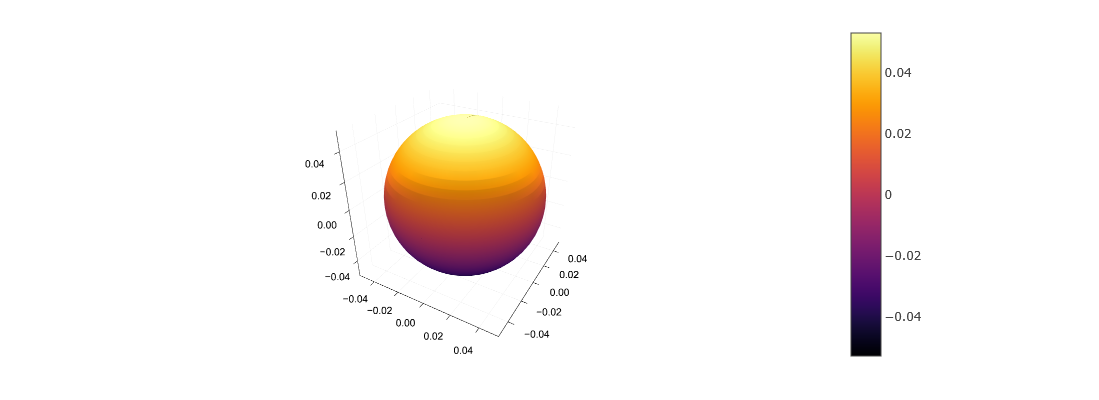

In [38]:
    B=10.0
    res=signals(B, par, laz, evecs, Doppler_steps)
    ρgg=res[3]
    ρee=res[4]
    ρggJ4=ρgg[1:9,1:9]
    J=4
    surface=plotProbSurf(J,ρggJ4)

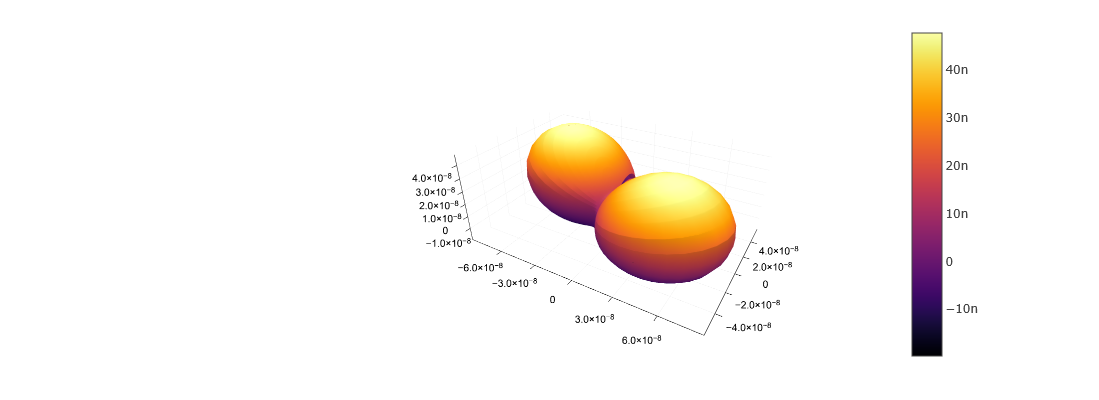

In [39]:
ρeeJ4=ρee[1:9,1:9]
surfaceExcited=plotProbSurf(J,ρeeJ4)

Processing magnetic field B₀=100.0 G.


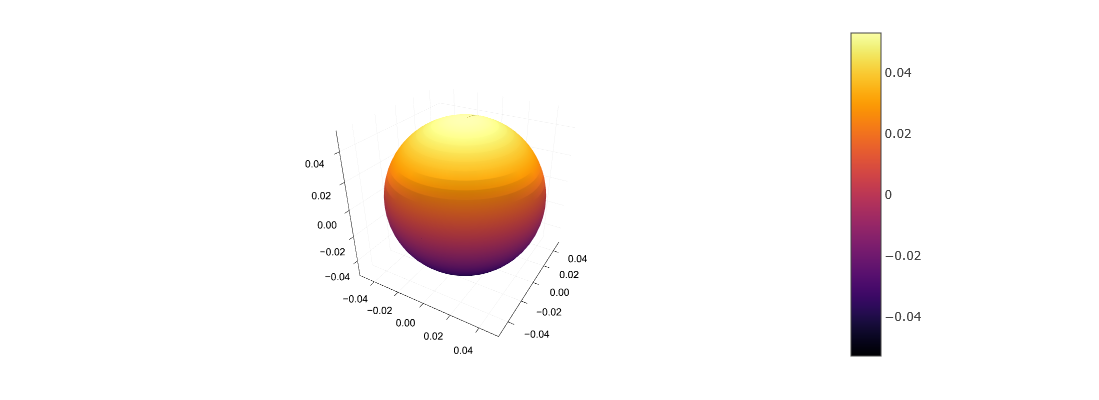

In [36]:
    B=100.0
    res=signals(B, par, laz, evecs, Doppler_steps)
    ρgg=res[3]
    ρee=res[4]
    ρggJ4=ρgg[1:9,1:9]
    J=4
    surface=plotProbSurf(J,ρggJ4)

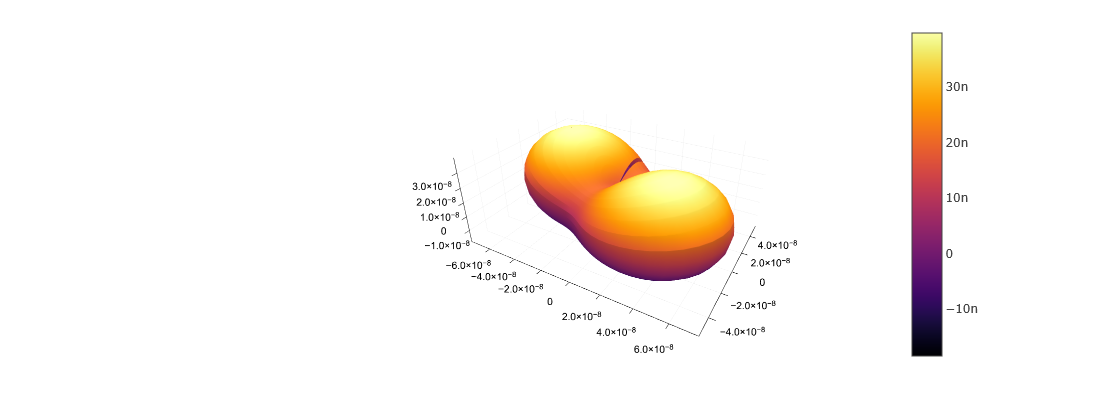

In [37]:
ρeeJ4=ρee[1:9,1:9]
surfaceExcited=plotProbSurf(J,ρeeJ4)

Processing magnetic field B₀=1000.0 G.


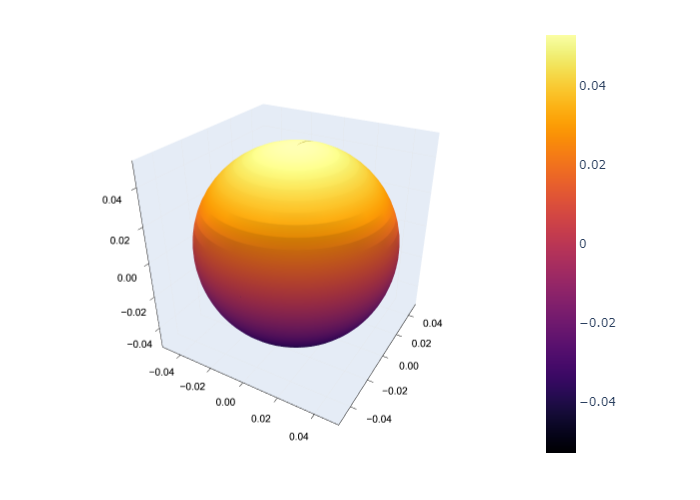

In [40]:
   B=1000.0
    res=signals(B, par, laz, evecs, Doppler_steps)
    ρgg=res[3]
    ρee=res[4]
    ρggJ4=ρgg[1:9,1:9]
    J=4
    surface=plotProbSurf(J,ρggJ4)
    

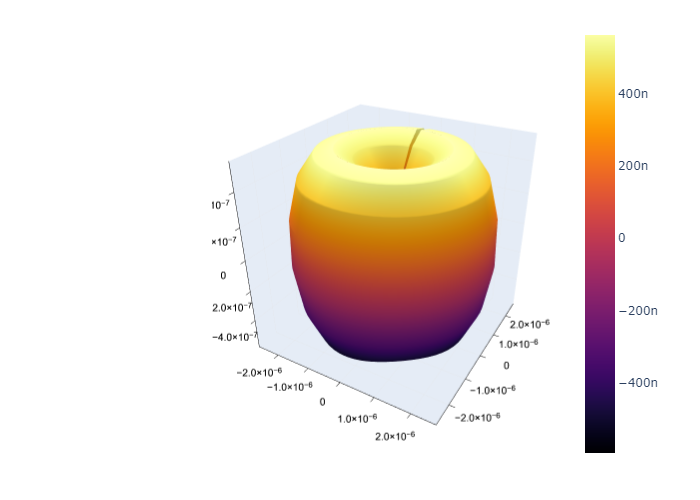

In [41]:
ρeeJ4=ρee[1:9,1:9]
surfaceExcited=plotProbSurf(J,ρeeJ4)